In [1]:
!pip install fastai
!pip install timm

In [2]:
from fastai.vision.all import *
import timm

/home/dnth/anaconda3/envs/fastdupv1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = Path('data/')

In [4]:
block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label, item_tfms=[Resize(150)],
        batch_tfms=aug_transforms(mult=1.5, size=150, min_scale=0.75))

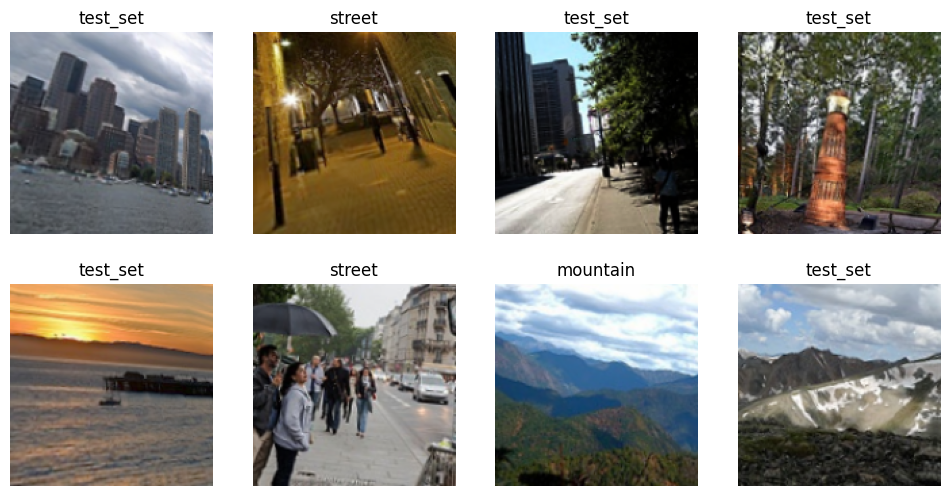

In [5]:
loaders = block.dataloaders(path)
loaders.train.show_batch(max_n=8, nrows=2)

In [6]:

timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [7]:
learn = vision_learner(loaders, 'convnext_tiny_in22k', metrics=accuracy).to_fp16()

SuggestedLRs(valley=0.0005754399462603033)

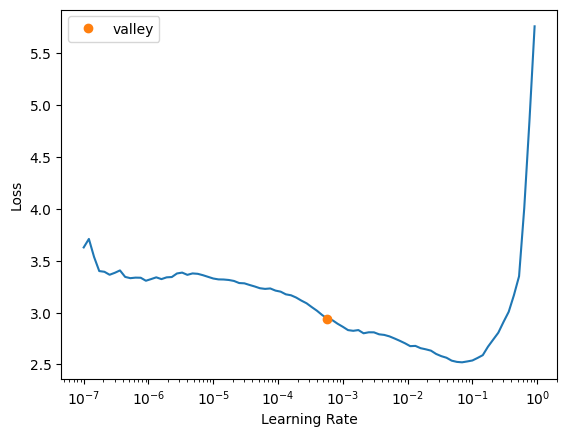

In [8]:
learn.lr_find()

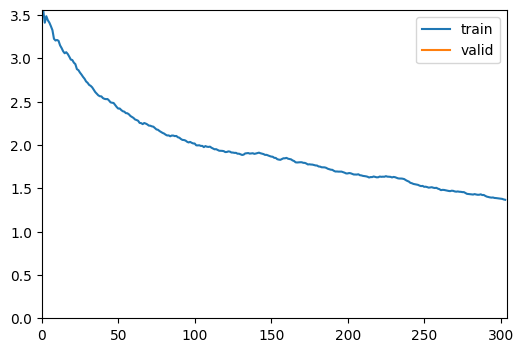

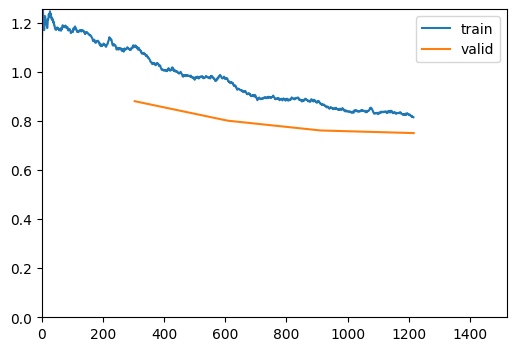

In [9]:
learn.fine_tune(5, base_lr=1e-3, cbs=[ShowGraphCallback()])

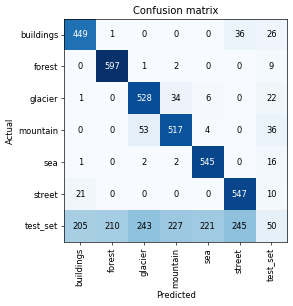

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

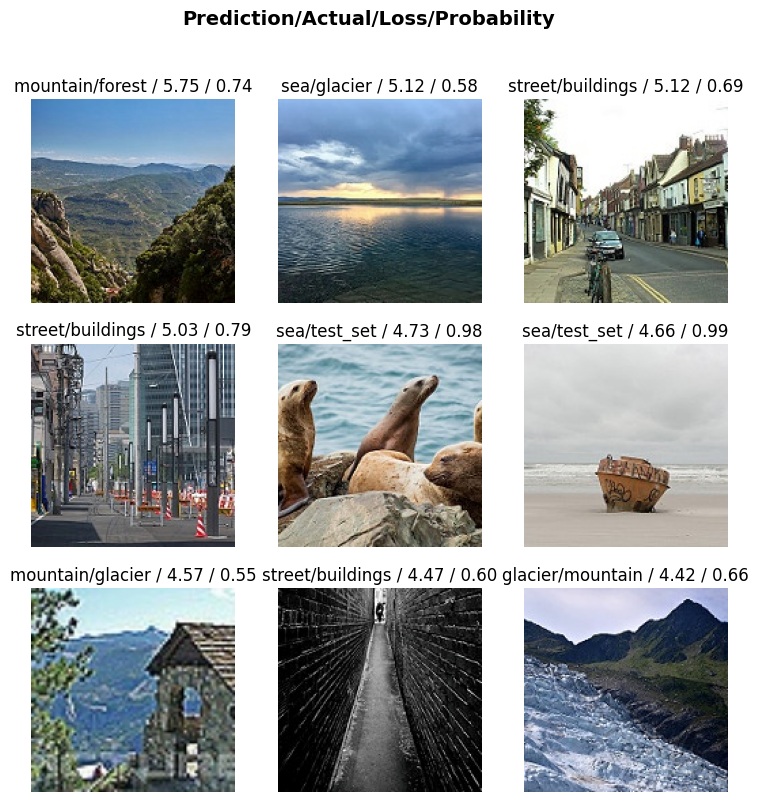

In [11]:
interp.plot_top_losses(9)

In [12]:
interp.most_confused

<bound method ClassificationInterpretation.most_confused of <fastai.interpret.ClassificationInterpretation object at 0x7fb5d738b790>>

mountain   61.53% confidence.   Image = 24272.jpg
mountain   60.42% confidence.   Image = 18698.jpg
forest   66.52% confidence.   Image = 19414.jpg
glacier   66.02% confidence.   Image = 18376.jpg
buildings   65.64% confidence.   Image = 5987.jpg
glacier   67.92% confidence.   Image = 3418.jpg
glacier   76.97% confidence.   Image = 22332.jpg
glacier   77.29% confidence.   Image = 4245.jpg
mountain   46.46% confidence.   Image = 494.jpg
mountain   80.56% confidence.   Image = 9945.jpg
buildings   56.09% confidence.   Image = 16475.jpg
forest   61.83% confidence.   Image = 7472.jpg
sea   82.97% confidence.   Image = 1349.jpg
street   76.91% confidence.   Image = 1109.jpg
forest   67.39% confidence.   Image = 11996.jpg
street   80.20% confidence.   Image = 6696.jpg
street   84.67% confidence.   Image = 21251.jpg
street   77.91% confidence.   Image = 12291.jpg
street   85.60% confidence.   Image = 21642.jpg
buildings   65.29% confidence.   Image = 6995.jpg


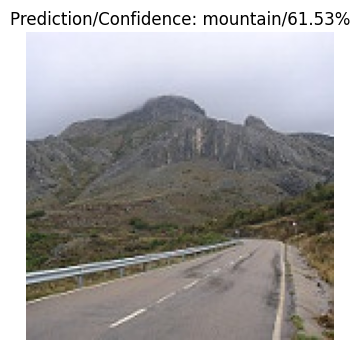

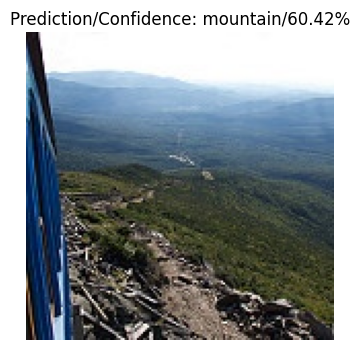

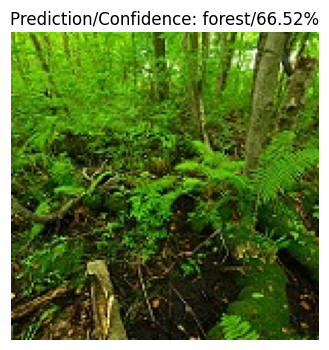

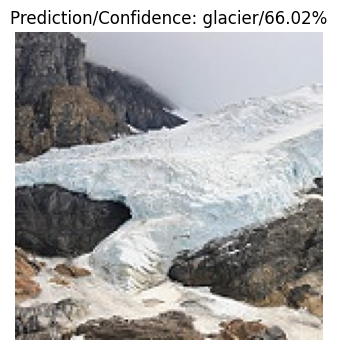

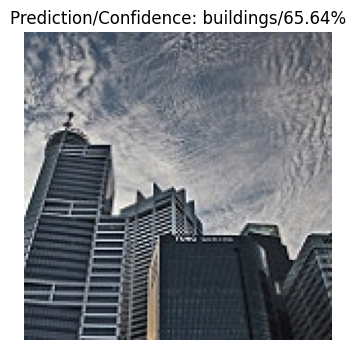

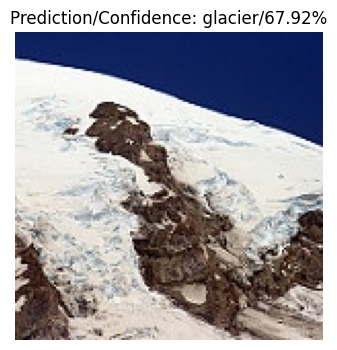

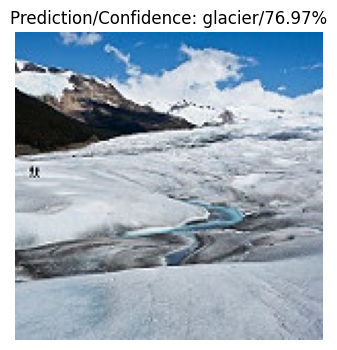

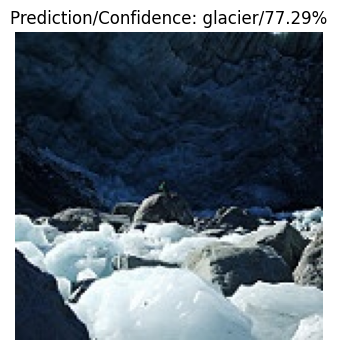

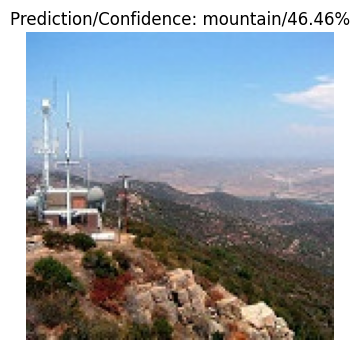

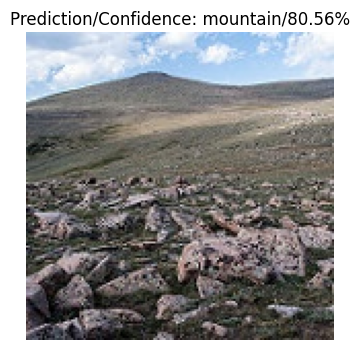

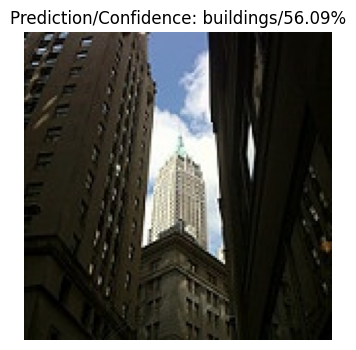

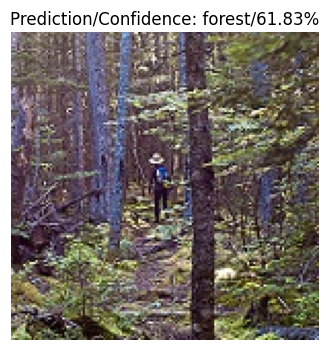

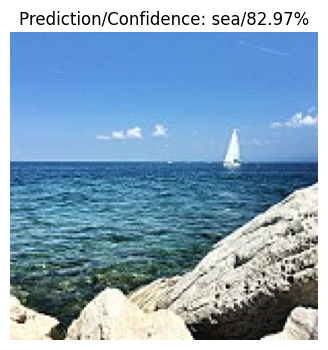

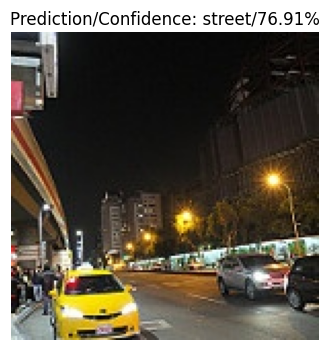

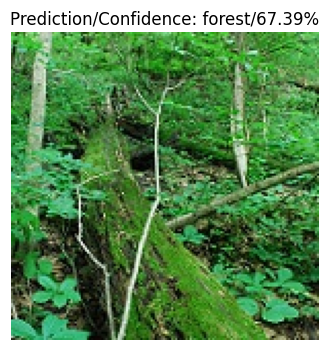

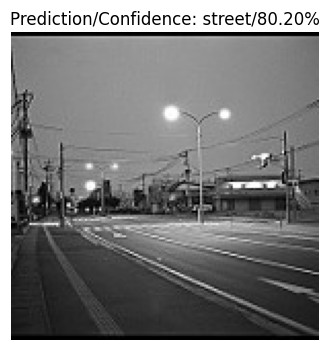

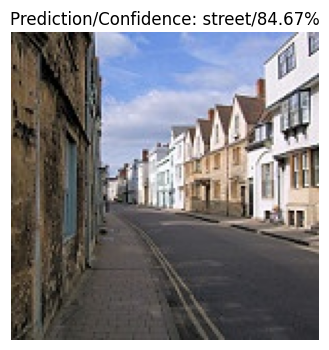

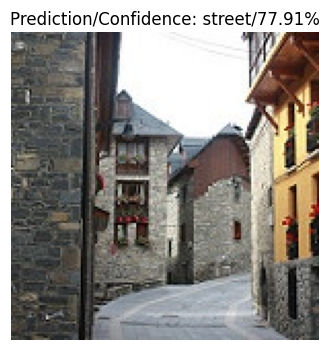

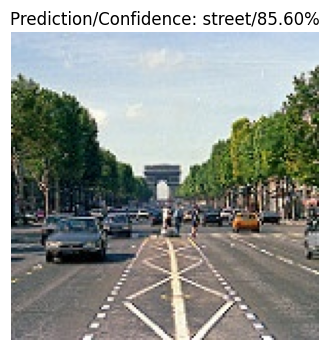

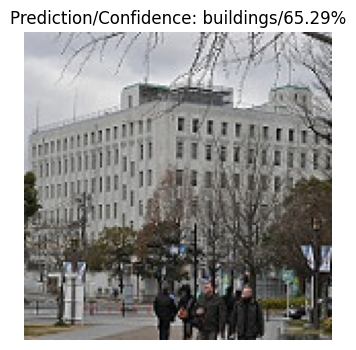

In [13]:
test_dl = learn.dls.test_dl(get_image_files('data/test_set/'))
preds = learn.get_preds(dl=test_dl)
num_images_to_show = 20
for index,item in enumerate(preds[0]):
    if index == num_images_to_show:
        break
    prediction = learn.dls.categorize.decode(np.argmax(item))
    confidence = max(item)
    percent = float(confidence)
    print(f"{prediction}   {percent*100:.2f}% confidence.   Image = {test_dl.items[index].name}")
    im = PILImage.create(test_dl.items[index])
    im.thumbnail((150,150))
    im.show(title=f'Prediction/Confidence: {prediction}/{percent*100:.2f}%')

    

In [14]:
learn.export("./models/learner.pkl")